<a href="https://colab.research.google.com/github/kushaal/Data_Mining_Term_Project/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random,os,glob
import pandas as pd
import torch
import torchvision
from tensorflow import keras
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization,SpatialDropout2D
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import tensorflow as tf
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models  import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
directory_path  = '/content/drive/My Drive/Garbage classification'

classes = os.listdir(directory_path)
print(classes)


['trash', 'glass', 'cardboard', 'metal', 'plastic', 'paper']


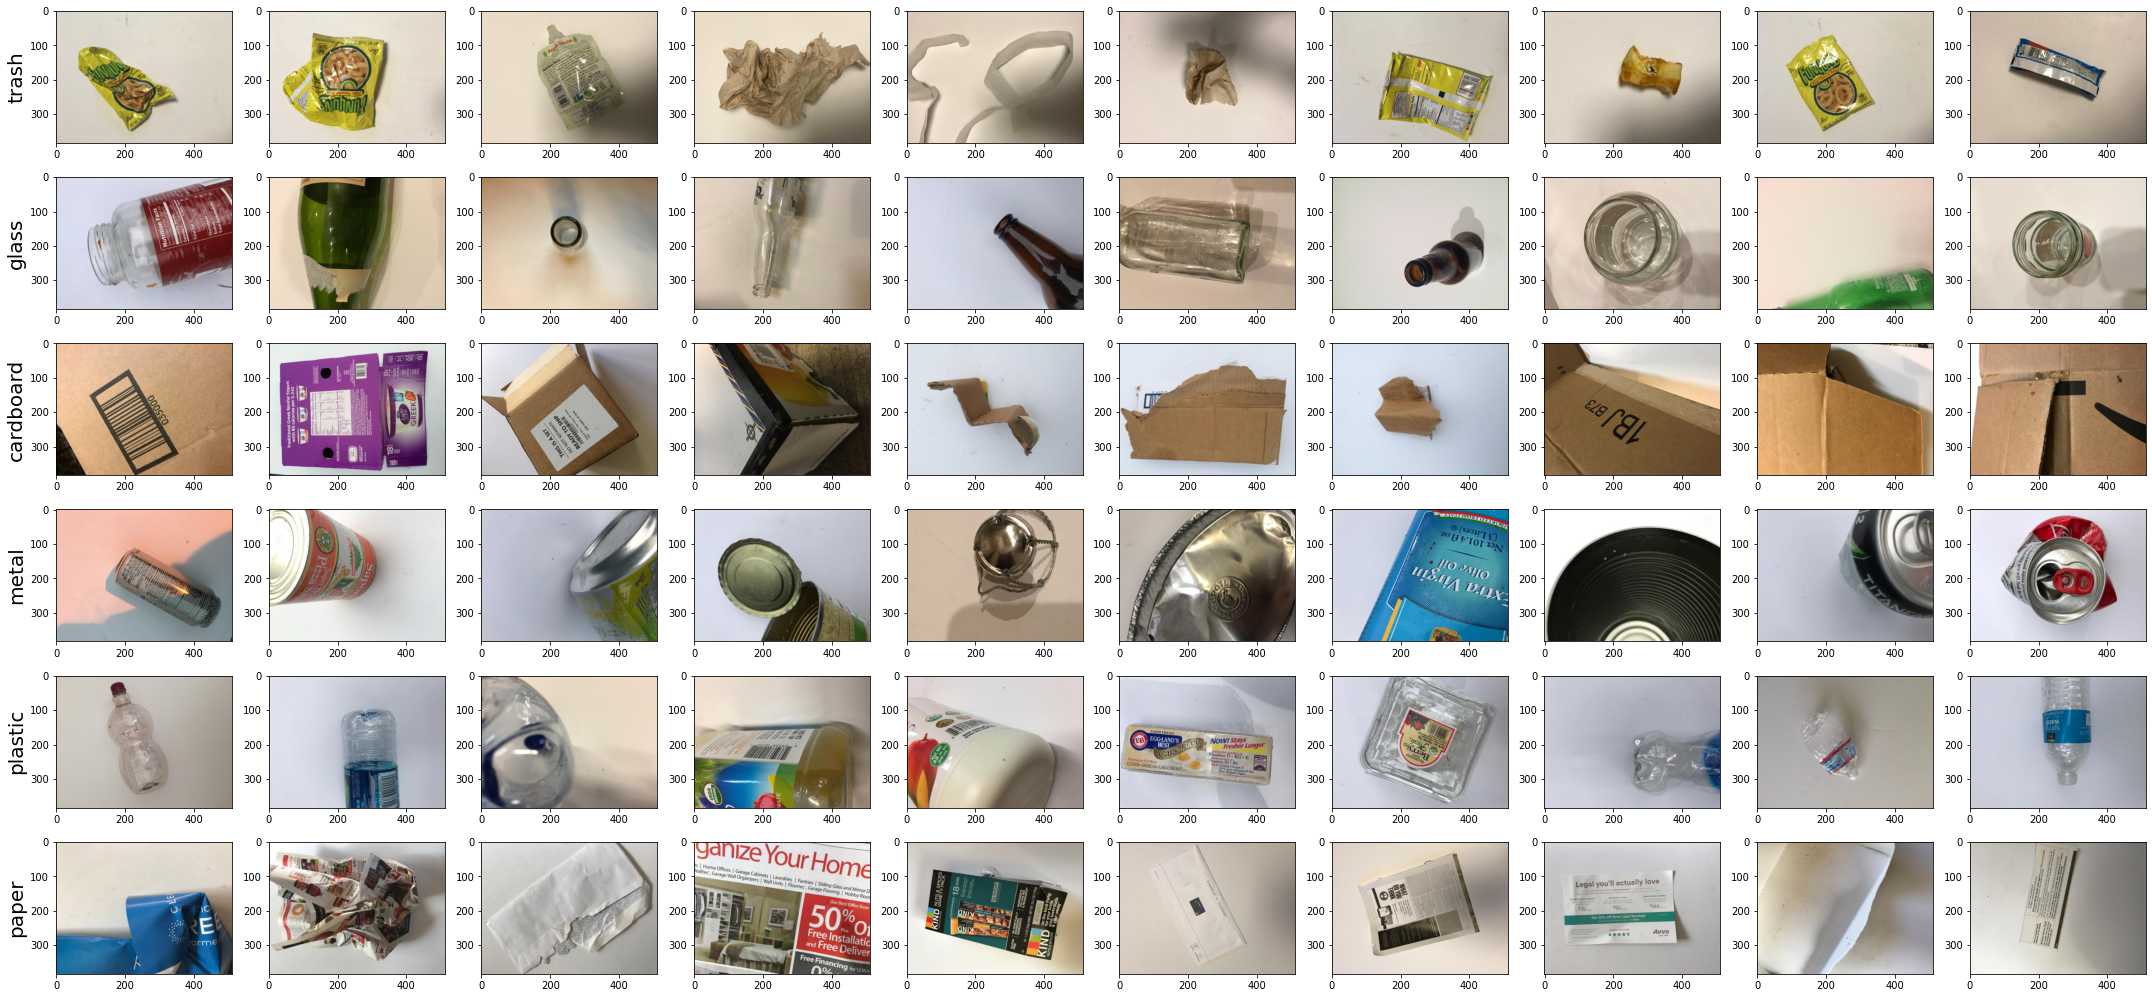

In [4]:
plt.figure(figsize=(30,14))

for i in range(6):
  dir = os.path.join(directory_path,classes[i])
  for j in range(10):
    path = os.path.join(dir, os.listdir(dir)[j])
    img = mpimg.imread(path)

    plt.subplot(6, 10, i*10 +j +1)
    plt.imshow(img)
    if j ==0:
      plt.ylabel(classes[i], fontsize=20)
plt.tight_layout()
plt.show()

In [5]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=15,
                         validation_split=0.2,
                         rescale=1./255,
                         shear_range = 0.1,
                         fill_mode="nearest",
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(directory_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(directory_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

validation_generator = train.flow_from_directory(directory_path, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2024 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [18]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(directory_path, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [19]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [28]:
#Using GPU for computation
def get_default_device():
    
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

device = get_default_device()


In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 512, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
    
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
    
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation='softmax')
])

train

In [ ]:
model.summary()

In [7]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(lr = 0.0001), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [9]:
train_datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                                   rotation_range=15,zoom_range=0.1,
                                   width_shift_range=0.15,height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255., 
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory_path, target_size=(384, 512), batch_size=32, class_mode='binary', subset='training')
validation_generator = train_datagen.flow_from_directory(directory_path, target_size=(384, 512), batch_size=32, class_mode='binary', subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [10]:
history = model.fit(train_generator, epochs=50, verbose=1, validation_data=validation_generator, callbacks=[callbacks])

Epoch 1/50
64/64 [==============================] - 155s 2s/step - loss: 1.8061 - accuracy: 0.5168 - val_loss: 3.8630 - val_accuracy: 0.1988
Epoch 2/50
64/64 [==============================] - 136s 2s/step - loss: 1.1835 - accuracy: 0.6028 - val_loss: 5.9485 - val_accuracy: 0.1988
Epoch 3/50
64/64 [==============================] - 136s 2s/step - loss: 1.1029 - accuracy: 0.6255 - val_loss: 6.4417 - val_accuracy: 0.1988
Epoch 4/50
64/64 [==============================] - 134s 2s/step - loss: 0.9893 - accuracy: 0.6640 - val_loss: 5.1940 - val_accuracy: 0.1988
Epoch 5/50
64/64 [==============================] - 134s 2s/step - loss: 0.8714 - accuracy: 0.6873 - val_loss: 4.4714 - val_accuracy: 0.1909
Epoch 6/50
64/64 [==============================] - 134s 2s/step - loss: 0.8719 - accuracy: 0.6927 - val_loss: 3.3278 - val_accuracy: 0.2306
Epoch 7/50
64/64 [==============================] - 113s 2s/step - loss: 0.9274 - accuracy: 0.6922 - val_loss: 2.1858 - val_accuracy: 0.2903
Epoch 8/50
64

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

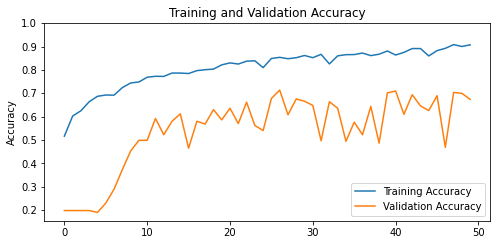

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

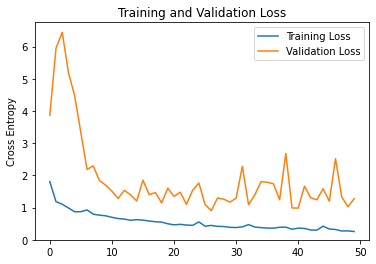

In [13]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()